# Problem description

Plot energy profiles of reco and sim tracksters.

The task gets much more difficult with the increasing overlap.

Two approaches for matching are possible:
- simtrackster that has the largest fraction of the reco trackster energy
- simtrackster in which the reco trackster makes up the largest fraction

In [1]:
import uproot
import awkward as ak
import numpy as np

import matplotlib.pyplot as plt

from reco.plotting import plot_event, plot_tracksters
from reco.energy import get_total_energy, get_energy_map
from reco.evaluation import bcubed, f_score
from reco.event import get_trackster_map, get_bary, get_lc
from reco.matching import get_highest_energy_fraction_simtracksters, match_best_simtrackster
from reco.distance import get_z_map

# %matplotlib widget
%matplotlib inline

data_root = "data"

ds_name = "MultiParticle"
ds_name = "CloseByTwoPion"

raw_dir = f"/Users/ecuba/data/{ds_name}"
file_name = f"{raw_dir}/new_ntuples_15163313_8.root"
file_name = f"{raw_dir}/new_ntuples_15101852_191.root"

plt.style.use('seaborn-whitegrid')

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
graphs = uproot.open({file_name: "ticlNtuplizer/graph"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

z_map = get_z_map(data_root)

In [34]:
eid = 0
E_TH = 2

# get layercluster layers and energy
e_lc = tracksters["vertices_energy"].array()[eid]
z_lc = tracksters["vertices_z"].array()[eid]

# get layercluster layers and energy
sim_e_lc = simtracksters["stsSC_vertices_energy"].array()[eid]
sim_z_lc = simtracksters["stsSC_vertices_z"].array()[eid]
sim_m_lc = simtracksters["stsSC_vertices_multiplicity"].array()[eid]

raw_e = tracksters["raw_energy"].array()[eid]

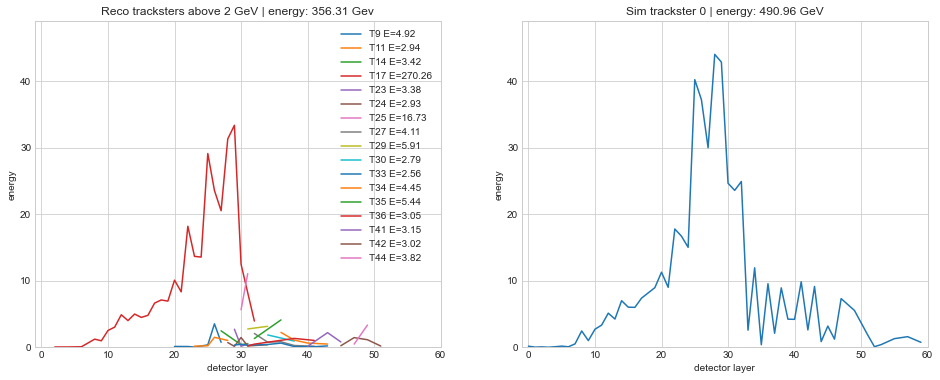

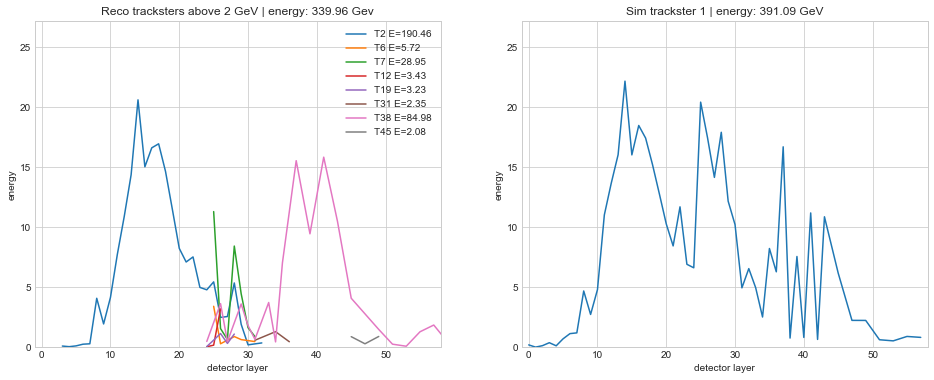

In [43]:
axs = []
ntx = min((20, len(sim_e_lc)))

simtrackster_energy = [0] * ntx
reconstructed_energy = [0] * ntx

for i in range(ntx):
    fig = plt.figure(figsize=(16, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    stm = sim_m_lc[i]
    ste = sim_e_lc[i] / stm

    stz = [z_map[x] for x in sim_z_lc[i]]

    st_agg = {}
    for e, z, m in zip(ste, stz, stm):
        if z in st_agg:
            st_agg[z] += e
        else:
            st_agg[z] = e
    
    st_arr = np.array(sorted(st_agg.items()))

    xmin = st_arr[0, 0] - 1
    xmax = st_arr[-1, 0] + 1
    ymax = max(st_arr[:, 1]) + 5
    
    ax1.set_xlabel("detector layer")
    ax1.set_ylabel("energy")
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(0, ymax)

    ax2.set_title(f"Sim trackster {i} | energy: {sum(ste):.2f} GeV")
    ax2.plot(st_arr[:,0], st_arr[:,1])
    ax2.set_xlabel("detector layer")
    ax2.set_ylabel("energy")
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(0, ymax)

    simtrackster_energy[i] += sum(ste)
    axs.append(ax1)

# _, reco_st = get_highest_energy_fraction_simtracksters(tracksters, simtracksters, associations, eid)
_, reco_st = match_best_simtrackster(tracksters, associations, eid)

for t_id in range(len(raw_e)):
    te = e_lc[t_id]
    tz = [z_map[x] for x in z_lc[t_id]]

    # aggregate per layer
    t_agg = {}
    for e, z in zip(te, tz):
        if z in t_agg:
            t_agg[z] += e
        else:
            t_agg[z] = e

    stid = reco_st[t_id]

    if stid >= ntx:
        continue

    ax = axs[stid]

    t_arr = np.array(sorted(t_agg.items()))
    reconstructed_energy[stid] += sum(te)
    
    if sum(te) > E_TH:
        ax.plot(t_arr[:,0], t_arr[:,1], label=f"T{t_id} E={sum(te):.2f}")
        ax.legend()

    ax.set_title(f"Reco tracksters above {E_TH} GeV | energy: {reconstructed_energy[stid]:.2f} Gev")

plt.show()

## Reconstructed energy

In [44]:
total_sim = np.array(simtrackster_energy)
total_reco = np.array(reconstructed_energy)
total_frac = 100*sum(total_reco)/sum(total_sim)

fractions = total_reco / total_sim

print(f"Total simtracksters energy: {sum(total_sim):.3f} GeV")
print(f"Total reconstructed energy: {sum(total_reco):.3f} Gev ({total_frac:.2f}%)")
print(f"Mean reconstruction: {100*np.mean(fractions):.2f}%")

Total simtracksters energy: 882.044 GeV
Total reconstructed energy: 696.270 Gev (78.94%)
Mean reconstruction: 79.75%


## Energy threshold

The goal is to connect low-energy tracksters to high-energy tracksters.

As visible on the plots below:
- reco has the most tracksters in the sub-10Gev range
- sim has none / much fewer

Note that this is in a zoomed in area (0, 100).
The goal is to reconnect all the tracksters in the sub 10 GeV Range to their larger counterparts.

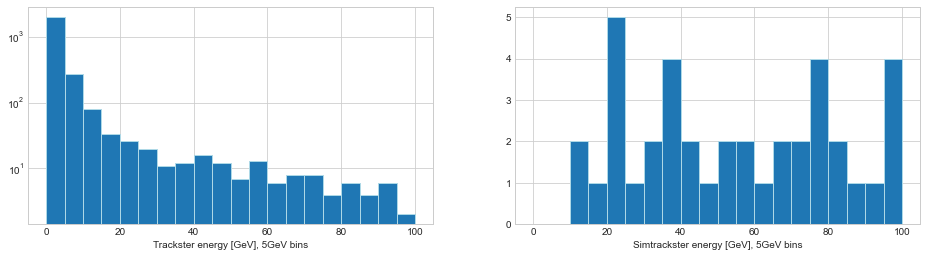

In [48]:
tenergy = ak.flatten(tracksters["raw_energy"].array())
stenergy = ak.flatten(simtracksters["stsSC_raw_energy"].array())

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(121)
ax.hist(tenergy, bins=20, edgecolor="lightblue", range=(0, 100))
ax.set_yscale("log")
ax.set_xlabel("Trackster energy [GeV], 5GeV bins")

ax = fig.add_subplot(122)
ax.set_xlabel("Simtrackster energy [GeV], 5GeV bins")
ax.hist(stenergy, bins=20, edgecolor="lightblue", range=(0, 100))
plt.show()